<a href="https://colab.research.google.com/github/kerryqliu/stats170/blob/irene/tf_idf_with_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
from sqlalchemy import create_engine

In [2]:
# ENGINE

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [13]:
query = "SELECT * from fullDocuments f join documentLabels d on f.docid = d.docid;"
fulldocs = pd.read_sql_query(query, con=engine)
fulldocs

,docid,fulltext,docid,caseid,label
0,1.0,Document Text: Example 1\nReferring Doctor: Un...,1,-1,1.0
1,2.0,Document Text: Example 2\nProgress Notes\nDate...,2,-1,1.0
2,3.0,Document Text: Example 3\nChief Complaint:\n1....,3,-1,4.0
3,4.0,Document Text: 14\nse\nLAIDA\n*\nPatient Infor...,4,11594,1.0
4,5.0,Document Text: The first set of documents behi...,5,11594,1.0
...,...,...,...,...,...
142,143.0,Document Text: Fax Server\nFAX CONFIDENTIAL\nT...,143,207261,2.0
143,144.0,Document Text: FAX COVER SHEET\nTO:\nDEPT:\nFA...,144,207365,2.0
144,145.0,Document Text: FAX COVER SHEET\nDATE:\nTO:\nPH...,145,207766,2.0
145,146.0,Document Text: Page 1/20\nPatient Profile\nRes...,146,207813,2.0


In [14]:
corpus_dict = {}
corpus = []
tags = []
for i, row in fulldocs.iterrows():
  corpus.append(row['fulltext'])
  tags.append(row['label'])
  corpus_dict[i] = (row['fulltext'], row['label'])

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')

In [27]:
# relevant words to use for 
with open('/content/drive/Shareddrives/CAPSTONE/Resources/importantwords.txt', 'r') as file:
  data = file.read()
  print(data.split('\n'))
  words = data.split('\n')
  words = list(set(words))

['focal', 'neuropathy', 'motor', 'extremity', 'weakness', 'right', 'left', 'lower', 'msr', 'msrs', 'biceps', 'triceps', 'brachioradialis', 'patellar', 'achilles', 'right', '+2', '0', '+3', '+2', 'reflexes', 'plantar', 'flexor', 'denervation', 'reinnervation', 'nerve', 'abnormalities', 'neurological', 'deficit', 'focal', 'atrophy', 'multifocal', 'chronic', 'inflammatory', 'demyelinating', 'neuromuscular', 'asymmetric', 'atrophy', 'forearm', 'hand', 'muscles', 'fasciculations', 'fasciculation', 'tingling', 'pain', 'wrist', 'dorsal', 'radial', 'conduction', 'reflex', 'throughout', 'toes', 'downgoing', 'distal', 'extremities', 'disease', 'cidp', 'radial', 'nerve', 'msucle', 'atrophy', 'bilateral', 'carpal', 'tunnel', 'ulnar', 'numbness', 'tingling', 'hands', 'hand', 'worse', 'severe', 'atrophy', 'bilateral', 'intrinsics', 'strength', 'triceps', 'tricep', 'demyelinating', 'asymmetric', 'nerves', 'ulnar', 'decreased', 'decrease', 'bilaterally', 'sensimotor', 'polyneuropathy', 'weak', 'weakne

### stratified kfold split

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold 
from sklearn.feature_extraction.text import TfidfVectorizer

In [24]:
corpus_np = np.array(corpus)
tags_np = np.array(tags)

In [25]:
from collections import defaultdict
from sklearn.metrics import accuracy_score, f1_score

In [26]:
skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=1)

In [29]:
vectorizer = TfidfVectorizer(ngram_range=(1,3))
test_docs = vectorizer.fit_transform(corpus)
vocabulary = vectorizer.get_feature_names()
final_vocab = []

# get overlapping words with relevant words and word vectors made from the document
for vocab in vocabulary:
  splits = vocab.split()
  for w in words:
    if w in splits:
      final_vocab.append(vocab)
      break

In [30]:
# get the vector matrix
vocabulary = vectorizer.get_feature_names()
test = pd.DataFrame(data=test_docs.toarray(), columns=vocabulary)
test[final_vocab]

,00 neuralgic,00 neuralgic amyotrophy,00 neuropathy,00 neuropathy associated,00 neuropathy due,00 problem chronic,00 sensory normal,000 negative,000 negative 3200,001 035 negative,003 re neurological,0036 lumbar,0036 lumbar spine,004 008 reduced,007 page normal,008 reduced,008 reduced amplitude,009 emg nerve,010 left,010 left right,013 ankles,013 ankles absent,02 ankle,02 ankle fib,02 chronic,02 chronic inflammatory,02 lesion,02 lesion lateral,02 motor,02 motor neuron,02 multifocal,02 multifocal motor,02 thalamic pain,023 deep tendon,033 negative,033 negative negative,035 negative,035 negative negative,039 polyneuropathy,039 polyneuropathy 356,...,yards fine motor,year cervical,year cervical and,year had fasciculations,year old left,year old right,year reason numbness,year right,year right handed,years and negative,years his weakness,years or weakness,yes assessments weakness,yes joint,yes joint pain,yes kidney disease,yes neck pain,yes tremors,yes tremors no,yes weakness,yes weakness yes,yet the neuropathic,young age focal,your pain,your pain overall,your present pain,ypertension ripheral neuropathy,z79 899 weakness,z80 neurological,z80 neurological exam,z87 39 neurological,zofran and normal,µv and decreased,µv decreased,µv decreased conduction,éhl left,éhl left large,ülnar wrist,ülnar wrist d5,č5 axillary left
0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022113,0.022113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [36]:
# one example
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(corpus, tags, test_size=0.33, random_state=42)

# # split corpus into train and test
# features_train, features_test = corpus_np[train_index], corpus_np[test_index]
# # split tags into train and test
# labels_train, labels_test = tags_np[train_index], tags_np[test_index]

# train tfidf vectorizer
features_train = vectorizer.fit_transform(features_train)
features_test = vectorizer.transform(features_test)

vocabulary = vectorizer.get_feature_names()
final_vocab = []

# get overlapping words with relevant words and word vectors made from the document
for vocab in vocabulary:
  splits = vocab.split()
  for w in words:
    if w in splits:
      final_vocab.append(vocab)
      break

# get the train vector matrix
train = pd.DataFrame(data=features_train.toarray(), columns=vocabulary)
# print(train[final_vocab])

# get the test vector matrix
test = pd.DataFrame(data=features_test.toarray(), columns=vocabulary)
# test[final_vocab]

    00 neuropathy  00 neuropathy associated  ...  ülnar wrist  ülnar wrist d5
0             0.0                       0.0  ...          0.0             0.0
1             0.0                       0.0  ...          0.0             0.0
2             0.0                       0.0  ...          0.0             0.0
3             0.0                       0.0  ...          0.0             0.0
4             0.0                       0.0  ...          0.0             0.0
..            ...                       ...  ...          ...             ...
93            0.0                       0.0  ...          0.0             0.0
94            0.0                       0.0  ...          0.0             0.0
95            0.0                       0.0  ...          0.0             0.0
96            0.0                       0.0  ...          0.0             0.0
97            0.0                       0.0  ...          0.0             0.0

[98 rows x 20474 columns]


In [42]:
curr_model = LogisticRegression(penalty = 'l1', solver = 'saga', C=100).fit(train[final_vocab], labels_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [43]:
labels_pred = curr_model.predict(test[final_vocab])
labels_train_pred = curr_model.predict(train[final_vocab])

print(accuracy_score(labels_train, labels_train_pred))
print(accuracy_score(labels_test, labels_pred))

0.8979591836734694
0.42857142857142855


In [ ]:
train_dict = defaultdict(list)
test_dict = defaultdict(list)
train_f1_dict = defaultdict(list)
test_f1_dict = defaultdict(list)
train_f1_macro_dict = defaultdict(list)
test_f1_macro_dict = defaultdict(list)

Cs = [1e-7, 1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5]

for c in Cs:
  print(f'-----{c}')

  for k in range(5): # perform k-fold 5 times

    print(f'-----------{k}')
    curr_train = []
    curr_test = []
    curr_f1_train = []
    curr_f1_test = []
    curr_f1_macro_train = []
    curr_f1_macro_test = []
    
    for train_index, test_index in skf.split(corpus, tags):
      # split corpus into train and test
      features_train, features_test = corpus_np[train_index], corpus_np[test_index]
      # split tags into train and test
      labels_train, labels_test = tags_np[train_index], tags_np[test_index]
      # train tfidf vectorizer
      features_train = vectorizer.fit_transform(features_train)
      features_test = vectorizer.transform(features_test)

      vocabulary = vectorizer.get_feature_names()
      final_vocab = []

      # get overlapping words with relevant words and word vectors made from the document
      for vocab in vocabulary:
        splits = vocab.split()
        for w in words:
          if w in splits:
            final_vocab.append(vocab)
            break

      # get the vector matrix
      vocabulary = vectorizer.get_feature_names()
      test = pd.DataFrame(data=test_docs.toarray(), columns=vocabulary)
      test[final_vocab]

      curr_model = LogisticRegression(penalty = 'l1', solver = 'saga', C=c).fit(features_train, labels_train)

      labels_pred = curr_model.predict(features_test)
      labels_train_pred = curr_model.predict(features_train)

      curr_train.append(accuracy_score(labels_train, labels_train_pred))
      curr_test.append(accuracy_score(labels_test, labels_pred))

      curr_f1_train.append(f1_score(labels_train, labels_train_pred, average='weighted'))
      curr_f1_test.append(f1_score(labels_test, labels_pred, average='weighted'))

      curr_f1_macro_train.append(f1_score(labels_train, labels_train_pred, average='macro'))
      curr_f1_macro_test.append(f1_score(labels_test, labels_pred, average='macro'))

    train_dict[c].append(curr_train)
    test_dict[c].append(curr_test)
    train_f1_dict[c].append(curr_f1_train)
    test_f1_dict[c].append(curr_f1_test)
    train_f1_macro_dict[c].append(curr_f1_macro_train)
    test_f1_macro_dict[c].append(curr_f1_macro_test)

-----1e-07
-----------0
-----------1
-----------2
-----------3
-----------4
-----1e-05
-----------0
-----------1
-----------2
-----------3
-----------4
-----0.001
-----------0
-----------1
-----------2
-----------3
-----------4
-----0.1
-----------0
-----------1
-----------2
-----------3
-----------4
-----1.0
-----------0
-----------1
-----------2
-----------3
-----------4
-----10.0
-----------0


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

-----------1


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

-----------2


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

-----------3


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

-----------4


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

-----100.0
-----------0


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

-----------1


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

-----------2


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

-----------3


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

-----------4


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

-----1000.0
-----------0


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

-----------1


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

-----------2


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

-----------3


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

-----------4


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

-----10000.0
-----------0


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

-----------1


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

-----------2


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

-----------3


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

-----------4


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

-----100000.0
-----------0


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

-----------1


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

-----------2


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

-----------3


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

-----------4


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

In [ ]:
train_mean = []
test_mean = []
f1_train_mean = []
f1_test_mean = []
f1_macro_train_mean = []
f1_macro_test_mean = []

for key in Cs:
  curr_train = []
  curr_test = []
  curr_f1_train = []
  curr_f1_test = []
  curr_f1_macro_train = []
  curr_f1_macro_test = []

  for scores in train_dict[key]:
    curr_train.append(sum(scores)/len(scores))

  for scores in test_dict[key]:
    curr_test.append(sum(scores)/len(scores))

  for scores in train_f1_dict[key]:
    curr_f1_train.append(sum(scores)/len(scores))

  for scores in test_f1_dict[key]:
    curr_f1_test.append(sum(scores)/len(scores))

  for scores in train_f1_macro_dict[key]:
    curr_f1_macro_train.append(sum(scores)/len(scores))

  for scores in test_f1_macro_dict[key]:
    curr_f1_macro_test.append(sum(scores)/len(scores))

  train_mean.append(sum(curr_train)/len(curr_train))
  test_mean.append(sum(curr_test)/len(curr_test))
  f1_train_mean.append(sum(curr_f1_train)/len(curr_f1_train))
  f1_test_mean.append(sum(curr_f1_test)/len(curr_f1_test))
  f1_macro_train_mean.append(sum(curr_f1_macro_train)/len(curr_f1_macro_train))
  f1_macro_test_mean.append(sum(curr_f1_macro_test)/len(curr_f1_macro_test))

In [ ]:
test_optimum = (test_mean.index(max(test_mean)), max(test_mean))
f1_test_optimum = (f1_test_mean.index(max(f1_test_mean)), max(f1_test_mean))
f1_macro_test_optimum = (f1_macro_test_mean.index(max(f1_macro_test_mean)), max(f1_macro_test_mean))

print(test_optimum, f1_test_optimum, f1_macro_test_optimum)

(9, 0.6096491228070174) (9, 0.5158786302674249) (9, 0.21687347101325596)


### error plots

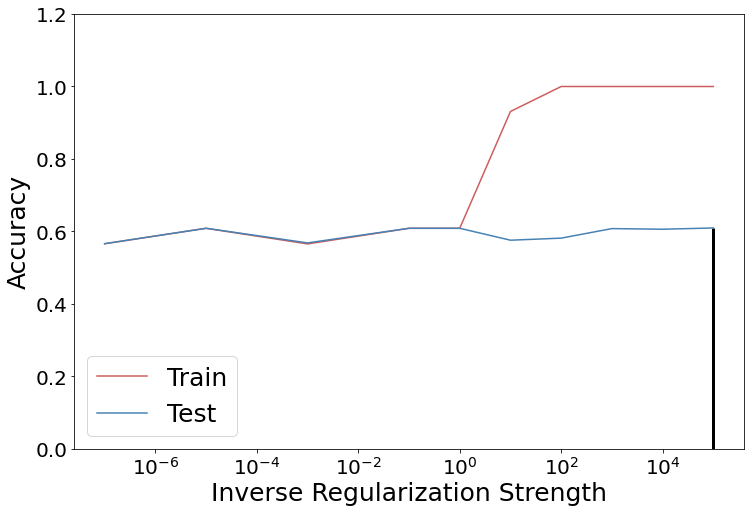

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,8))
plt.semilogx(Cs, train_mean, label='Train', color='indianred')
plt.semilogx(Cs, test_mean, label='Test', color='steelblue')
plt.ylim([0, 1.2])
plt.vlines(Cs[test_optimum[0]], plt.ylim()[0], test_optimum[1], color='k',
           linewidth=3)
plt.xlabel('Inverse Regularization Strength', fontsize=25)
plt.ylabel('Accuracy', fontsize=25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(loc='lower left', prop={'size': 25})
plt.show()

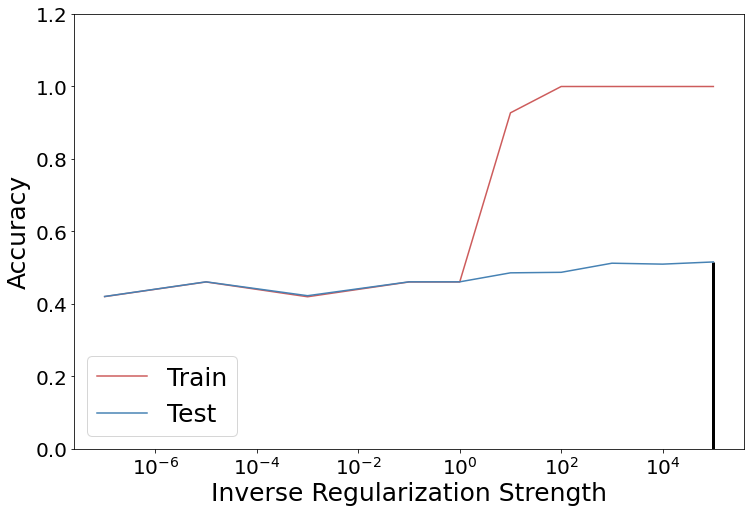

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,8))
plt.semilogx(Cs, f1_train_mean, label='Train', color='indianred')
plt.semilogx(Cs, f1_test_mean, label='Test', color='steelblue')
plt.ylim([0, 1.2])
plt.vlines(Cs[f1_test_optimum[0]], plt.ylim()[0], f1_test_optimum[1], color='k',
           linewidth=3)
plt.xlabel('Inverse Regularization Strength', fontsize=25)
plt.ylabel('Accuracy', fontsize=25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(loc='lower left', prop={'size': 25})
plt.show()

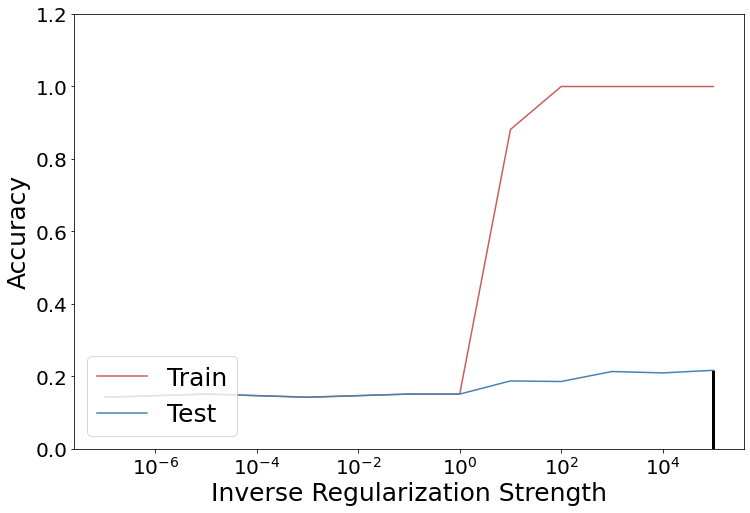

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,8))
plt.semilogx(Cs, f1_macro_train_mean, label='Train', color='indianred')
plt.semilogx(Cs, f1_macro_test_mean, label='Test', color='steelblue')
plt.ylim([0, 1.2])
plt.vlines(Cs[f1_macro_test_optimum[0]], plt.ylim()[0], f1_macro_test_optimum[1], color='k',
           linewidth=3)
plt.xlabel('Inverse Regularization Strength', fontsize=25)
plt.ylabel('Accuracy', fontsize=25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(loc='lower left', prop={'size': 25})
plt.show()